In [1]:
import pyabc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import tempfile

In [2]:
def verhulst(K:int, r:float):
    def growth_rate(t,x):
        return r*x*(1-(x/K))
    return growth_rate

In [3]:
K=900
r=3
mygrowth = verhulst(K,r)
x0 = np.ones(1)
t_max = 1/20*K*(1/r)
solution = scipy.integrate.solve_ivp(fun = mygrowth, t_span = (0,t_max), y0=x0)

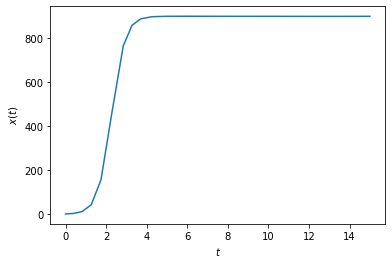

In [4]:
t = solution['t']
y = solution['y'][0]

plt.plot(t, y)
plt.xlabel('$t$')
plt.ylabel('$x(t)$')

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

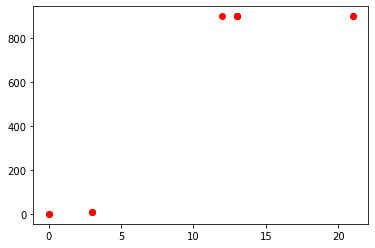

In [5]:
sample_size = 10
data_timepoints = np.random.randint(0,len(t),sample_size)
data = y[data_timepoints]
plt.plot(data_timepoints, data, 'ro')
plt.show

In [6]:
def sample_MVN(mean, cov):
    def sample_prior():
        return np.random.multivariate_normal(mean, cov)
    return sample_prior

In [35]:
mean = [3,1000]
cov = [[1,0],[0,50]]

#prior = sample_MVN(mean, cov)
prior = pyabc.Distribution(K=pyabc.RV("norm", 1000, 50), r=pyabc.RV("uniform", 0, 5))
prior.get_parameter_names()
print(prior)

<Distribution 'K', 'r'>


In [22]:
def distance(simulation, data):
    return np.absolute(data["X_2"] - simulation["X_2"]).sum()

In [23]:
measurement_times= np.arange(len(data))
init = np.array([1])
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "testODE.db"))

In [24]:
def f(y, t0, K, r):
    dy = r*y*(1-(y/K))
    return dy

def model(pars):
    sol = scipy.integrate.odeint(f, init, measurement_times, 
                                 args=(pars["K"], pars["r"]))
    return {"X_2": sol}
    

<function matplotlib.pyplot.show(*args, **kw)>

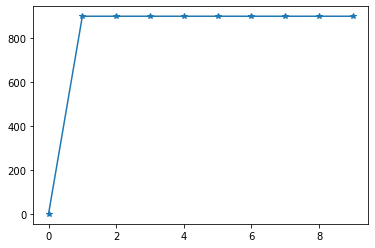

In [26]:
pars = {"K":900, "r":50}
sol = model(pars)
plt.plot(sol["X_2"],"*-")
plt.show

In [30]:
redis_sampler = pyabc.sampler.RedisEvalParallelSampler(host="localhost", port=6379)

abc = pyabc.ABCSMC(models = model,
                  parameter_priors=prior,
                  distance_function=distance,
                  population_size=100,
                  sampler=redis_sampler,
                  transitions=pyabc.LocalTransition(k_fraction=.3),
                  eps=pyabc.MedianEpsilon(500,median_multiplier=0.7))

In [31]:
abc.new(db_path, {"X_2": data})

INFO:History:Start <ABCSMC(id=3, start_time=2020-09-21 17:02:17.590833, end_time=None)>


In [32]:
h=abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:ABC:t: 0, eps: 500.


KeyboardInterrupt: 